In [2]:
# import the necessary packages 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

In [174]:
train = pd.read_csv("C:\\Users\\Punit\\Downloads\\tour_logs_train.csv")
test = pd.read_csv("C:\\Users\\Punit\\Downloads\\tour_logs_test_input.csv")

In [175]:
train.head(1)

,Gig_ID,Venue_ID,Show_DateTime,Day_of_Week,Volume_Level,Ticket_Price,Crowd_Size,Opener_Rating,Weather,Moon_Phase,Band_Outfit,Merch_Sales_Post_Show,Crowd_Energy
0,Gig_0000,V_Alpha,2024-03-07 21:00:00,3,5.0,52.93,464.0,2,Rainy,Waning Crescent,Leather,916,64.96


In [176]:
leakage_cols = [
    "Merch_Sales_Post_Show"
]

train = train.drop(columns=[c for c in leakage_cols if c in train.columns])
test = test.drop(columns=[c for c in leakage_cols if c in test.columns])

In [177]:
train['Show_DateTime'] = pd.to_datetime(train['Show_DateTime'], errors='coerce')

tmp = train.dropna(subset=['Show_DateTime']).copy()
tmp['weekday'] = tmp['Show_DateTime'].dt.weekday

weekday_dist = (
    tmp.groupby('Venue_ID')['weekday']
       .value_counts(normalize=True)
       .to_dict()
)

import random
from datetime import timedelta

def impute_datetime(row):
    if pd.notna(row['Show_DateTime']):
        return row['Show_DateTime']
    
    venue = row['Venue_ID']
    
    # Fallback: global distribution if venue unseen
    probs = {
        k[1]: v for k, v in weekday_dist.items() if k[0] == venue
    }
    
    if not probs:
        probs = tmp['weekday'].value_counts(normalize=True).to_dict()
    
    sampled_weekday = random.choices(
        list(probs.keys()),
        weights=list(probs.values())
    )[0]
    
    # Use a reference date (median date in dataset)
    base_date = tmp['Show_DateTime'].median()
    
    # Shift base_date to sampled weekday
    delta = (sampled_weekday - base_date.weekday()) % 7
    return base_date + timedelta(days=delta)

train['Show_DateTime'] = train.apply(impute_datetime, axis=1)

In [178]:
def clean_ticket_price(x):
    if pd.isna(x):
        return np.nan
    
    x = str(x).strip()
    
    if x.lower() == "free":
        return 0.0
    
    try:
        if x.startswith("£"):
            return float(x[1:]) * 1.27
        elif x.startswith("€"):
            return float(x[1:]) * 1.09
        elif x.startswith("$"):
            return float(x[1:])
        else:
            return float(x)
    except:
        return np.nan

train['Ticket_Price'] = train['Ticket_Price'].apply(clean_ticket_price)
test['Ticket_Price'] = test['Ticket_Price'].apply(clean_ticket_price)

train.loc[train['Ticket_Price'] > 100, 'Ticket_Price'] = np.nan
train.loc[train['Ticket_Price'] < 0, 'Ticket_Price'] = np.nan

In [179]:
# Remove impossible energy values - more critical
train = train[(train['Crowd_Energy'] >= 0) & (train['Crowd_Energy'] <= 100)]

In [180]:
# Crowd count must be realistic (venue capacity ~800-1000)
train.loc[train['Crowd_Size'] > 1200, 'Crowd_Size'] = np.nan
train.loc[train['Crowd_Size'] < 0, 'Crowd_Size'] = np.nan

In [181]:
# Volume sensor failures
train.loc[train['Volume_Level'] == 0, 'Volume_Level'] = np.nan
test.loc[test['Volume_Level'] == 0, 'Volume_Level'] = np.nan

In [182]:
cols_cannot_be_negative = [
    'Crowd_Size',
    'Volume_Level',
    'Ticket_Price'
]

for col in cols_cannot_be_negative:
    train.loc[train[col] < 0, col] = np.nan
    test.loc[test[col] < 0, col] = np.nan

In [183]:
num_cols = [
    'Crowd_Size',
    'Volume_Level',
    'Ticket_Price'
]

for col in num_cols:
    train[col] = train.groupby('Venue_ID')[col].transform(
        lambda x: x.fillna(x.median())
    )
    
    test[col] = test.groupby('Venue_ID')[col].transform(
        lambda x: x.fillna(x.median())
    )

In [184]:
train[train['Show_DateTime'].notna()].head(50)

,Gig_ID,Venue_ID,Show_DateTime,Day_of_Week,Volume_Level,Ticket_Price,Crowd_Size,Opener_Rating,Weather,Moon_Phase,Band_Outfit,Crowd_Energy
0,Gig_0000,V_Alpha,2024-03-07 21:00:00,3,5.0,52.9300,464.0,2,Rainy,Waning Crescent,Leather,64.96
1,Gig_0001,V_Beta,2024-09-05 22:00:00,3,2.0,66.3300,388.0,5,Clear,New Moon,Leather,66.42
2,Gig_0002,V_Delta,2024-03-09 15:00:00,5,1.0,51.3700,679.0,1,Rainy,Waning Crescent,Denim,42.58
3,Gig_0003,V_Beta,2024-08-07 08:00:00,0,10.0,64.7700,454.0,1,Rainy,New Moon,Leather,0.00
4,Gig_0004,V_Delta,2024-04-26 17:00:00,4,8.0,47.3400,654.0,5,Cloudy,Full Moon,Spandex,67.55
5,Gig_0005,V_Alpha,2024-09-11 20:00:00,2,3.0,69.6300,320.0,4,Cloudy,First Quarter,Denim,67.87
6,Gig_0006,V_Gamma,2024-04-09 19:00:00,1,4.0,69.4563,107.0,3,Clear,New Moon,Leather,85.45
7,Gig_0007,V_Alpha,2024-06-06 20:00:00,3,2.0,77.1700,637.0,3,Cloudy,Waning Crescent,Spandex,66.75
8,Gig_0008,V_Gamma,2024-03-12 17:00:00,1,8.0,48.0472,539.0,5,Clear,New Moon,Leather,40.85
9,Gig_0009,V_Delta,2024-03-21 19:00:00,3,9.0,43.0900,488.0,3,Cloudy,First Quarter,Spandex,43.92


In [185]:
for col in num_cols:
    train[col] = train[col].fillna(train[col].median())
    test[col] = test[col].fillna(train[col].median())

In [186]:
train.isnull().sum()

Gig_ID           0
Venue_ID         0
Show_DateTime    0
Day_of_Week      0
Volume_Level     0
Ticket_Price     0
Crowd_Size       0
Opener_Rating    0
Weather          0
Moon_Phase       0
Band_Outfit      0
Crowd_Energy     0
dtype: int64

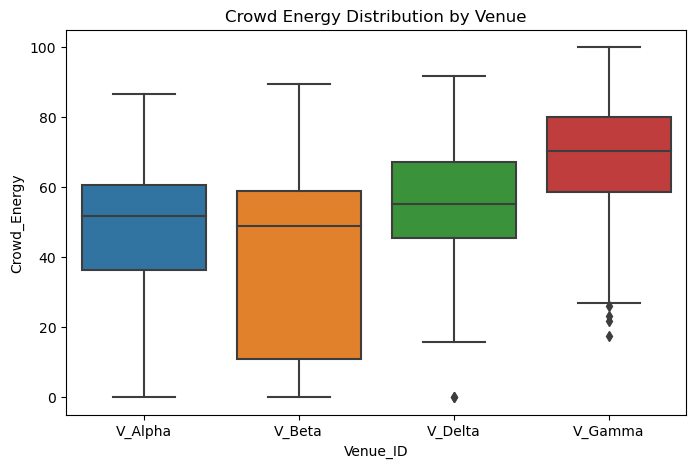

In [187]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.boxplot(x='Venue_ID', y='Crowd_Energy', data=train)
plt.title('Crowd Energy Distribution by Venue')
plt.show()

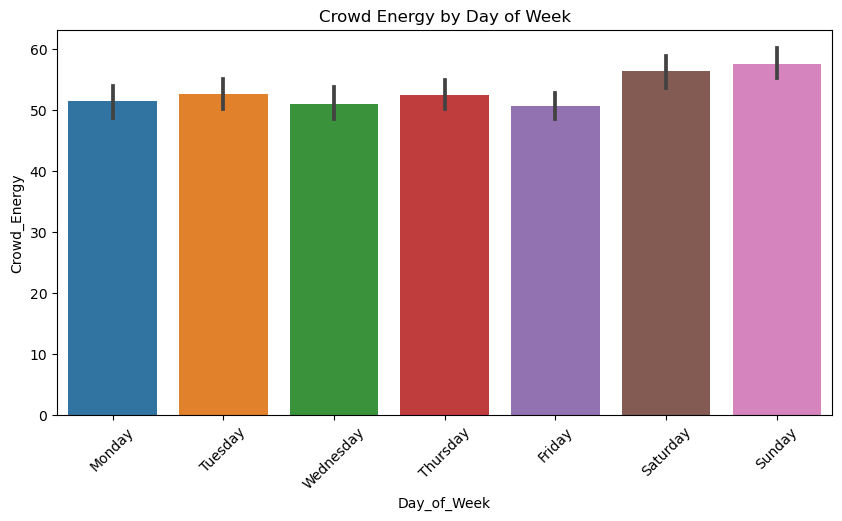

In [188]:
plt.figure(figsize=(10,5))
sns.barplot(
    x='Day_of_Week',
    y='Crowd_Energy',
    data=train,
    order=[0,1,2,3,4,5,6]
)
plt.xticks(
    ticks=[0,1,2,3,4,5,6],
    labels=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],
    rotation=45
)
plt.title('Crowd Energy by Day of Week')
plt.show()

Tuesday shows exhibit a slightly lower median and mean crowd energy compared to most other weekdays. While the effect is not 
extreme, the consistency across both distribution and mean-based plots suggests partial support for the 
singer’s ‘Tuesday curse’ hypothesis.

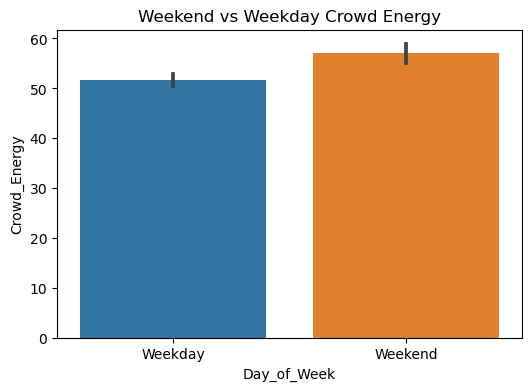

In [189]:
plt.figure(figsize=(6,4))
sns.barplot(
    x=train['Day_of_Week'].isin([5,6]),
    y=train['Crowd_Energy']
)
plt.xticks([0,1], ['Weekday','Weekend'])
plt.title('Weekend vs Weekday Crowd Energy')
plt.show()

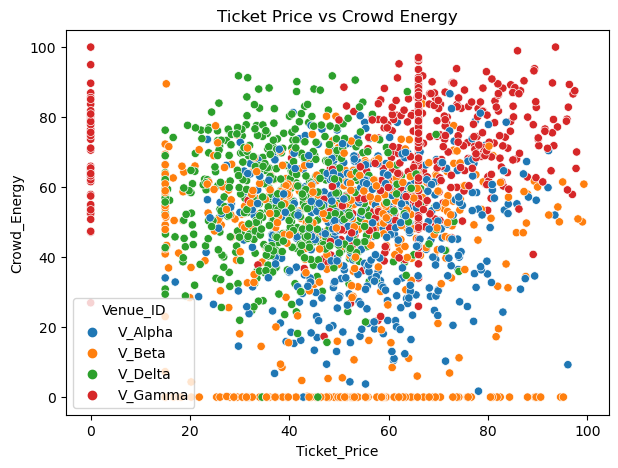

In [190]:
plt.figure(figsize=(7,5))
sns.scatterplot(x='Ticket_Price', y='Crowd_Energy', hue='Venue_ID', data=train)
plt.title('Ticket Price vs Crowd Energy')
plt.show()

The scatter plot illustrates the relationship between ticket price and crowd
energy across different venues. Overall, there is no strong global linear
relationship between price and energy; at most price levels, crowd energy
varies widely. However, clear venue-specific patterns emerge. V_Gamma shows
consistently higher energy at mid-to-high price ranges, suggesting a positive
price–energy association in that venue. In contrast, V_Alpha and V_Beta
exhibit weaker or inconsistent relationships, indicating that factors other
than price dominate crowd engagement. V_Delta displays high-energy outcomes
even at moderate prices, supporting the idea that crowd dynamics rather than
pricing drive energy. This highlights that ticket price effects are strongly
contextual and interact with venue characteristics.

"Paying more for a ticket does not automatically lead to a more energetic crowd; the venue and crowd type matter far more than the price itself.”

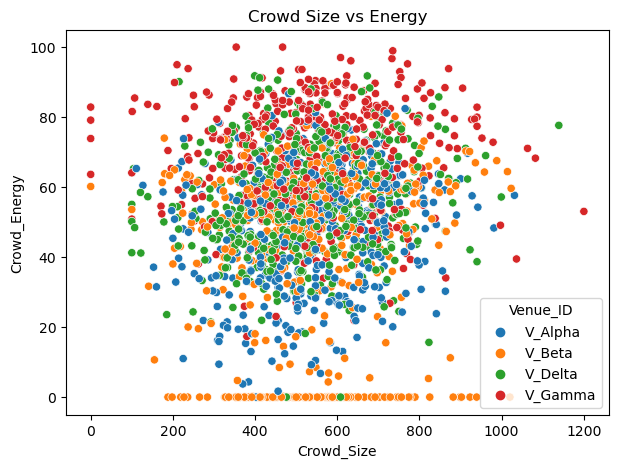

In [191]:
plt.figure(figsize=(7,5))
sns.scatterplot(x='Crowd_Size', y='Crowd_Energy', hue='Venue_ID', data=train)
plt.title('Crowd Size vs Energy')
plt.show()

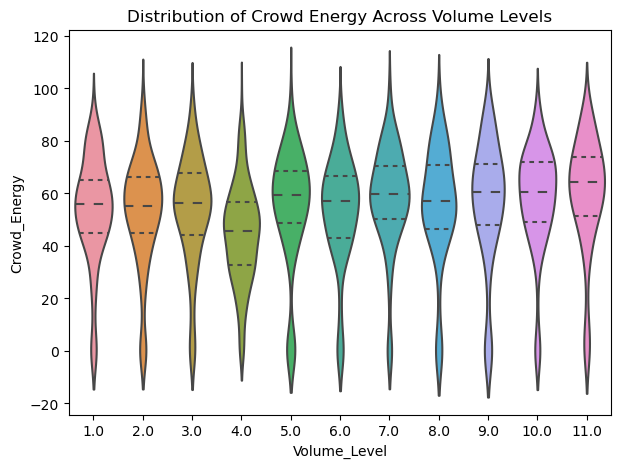

In [192]:
plt.figure(figsize=(7,5))
sns.violinplot(
    x='Volume_Level',
    y='Crowd_Energy',
    data=train[train['Volume_Level'] <= 20],
    inner='quartile'
)
plt.title('Distribution of Crowd Energy Across Volume Levels')
plt.show()


After removing extreme volume outliers caused by sensor glitches, the
relationship between volume level and crowd energy remains weak and
non-linear. While some venues show slightly higher energy at increased
volumes, substantial variation exists at all volume levels, indicating
that volume alone is not a reliable predictor of crowd energy.


# FEATURE ENGINEERING (HIGH WEIGHT)

In [193]:
# (handles non-linearity) 50->100 not equal 900->1000
train['log_crowd'] = np.log1p(train['Crowd_Size'])
test['log_crowd'] = np.log1p(test['Crowd_Size'])

In [194]:
# captures affordability relative to crowd, Whether a show feels “packed and cheap” or “expensive and empty”
train['price_per_person'] = train['Ticket_Price'] / (train['Crowd_Size'] +1)
test['price_per_person'] = test['Ticket_Price'] / (test['Crowd_Size'] +1)

In [195]:
# Loudness effects are non-linear, squaring emphasizes high-volume events
train['volume_squared'] = train['Volume_Level'] ** 2
test['volume_squared'] = test['Volume_Level'] ** 2

In [196]:
drop_cols = [
    'Gig_ID',        # identifier
    'Crowd_Size',    # replaced by log
    'Show_DateTime'
]

X = train.drop(columns=drop_cols + ['Crowd_Energy'])
y = train['Crowd_Energy']

X_test = test.drop(columns=drop_cols)

# BASELINE MODEL (REQUIRED)

In [197]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [198]:
cat_cols = X.select_dtypes(include='object').columns
num_cols = X.select_dtypes(exclude='object').columns

preprocessor = ColumnTransformer([
    ('num', 'passthrough', num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

In [199]:
train.head(1)

,Gig_ID,Venue_ID,Show_DateTime,Day_of_Week,Volume_Level,Ticket_Price,Crowd_Size,Opener_Rating,Weather,Moon_Phase,Band_Outfit,Crowd_Energy,log_crowd,price_per_person,volume_squared
0,Gig_0000,V_Alpha,2024-03-07 21:00:00,3,5.0,52.93,464.0,2,Rainy,Waning Crescent,Leather,64.96,6.142037,0.113828,25.0


In [171]:
# baseline = Pipeline([
#     ('prep', preprocessor),
#     ('model', LinearRegression())
# ])

# rmse = -cross_val_score(
#     baseline, X, y,
#     scoring='neg_root_mean_squared_error',
#     cv=5
# ).mean()

# print("Baseline RMSE:", rmse)

Baseline RMSE: 18.191601810485725


In [200]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

gbr = Pipeline([
    ('prep', preprocessor),
    ('model', GradientBoostingRegressor(random_state=42))
])

rmse_gbr = -cross_val_score(
    gbr,
    X,
    y,
    scoring='neg_root_mean_squared_error',
    cv=5
).mean()

print("Gradient Boosting RMSE (default):", rmse_gbr)

Gradient Boosting RMSE (default): 17.487798905699073


# ADVANCED MODEL + HYPERPARAMETER TUNING

In [172]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [173]:
rf = Pipeline([
    ('prep', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2]
}

grid = GridSearchCV(
    rf,
    param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid.fit(X, y)

print("Best RMSE:", -grid.best_score_)
print("Best params:", grid.best_params_)

Best RMSE: 17.541205030770833
Best params: {'model__max_depth': 10, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__n_estimators': 200}


A tuned Random Forest model improved performance slightly over the linear
baseline, achieving an RMSE of approximately 17.5. The modest improvement
suggests that while non-linear interactions exist, a significant portion of
the signal is already captured by the engineered features, and the remaining
variance may be driven by unobserved or inherently noisy factors.

# Gradient Boosting

In [201]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'model__n_estimators': [100, 200],
    'model__learning_rate': [0.05, 0.1],
    'model__max_depth': [2, 3, 4],
    'model__subsample': [0.8, 1.0]
}

gbr_tuned = Pipeline([
    ('prep', preprocessor),
    ('model', GradientBoostingRegressor(random_state=42))
])

grid_gbr = GridSearchCV(
    gbr_tuned,
    param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_gbr.fit(X, y)

print("Best Gradient Boosting RMSE:", -grid_gbr.best_score_)
print("Best params:", grid_gbr.best_params_)

Best Gradient Boosting RMSE: 17.379148683141835
Best params: {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 100, 'model__subsample': 0.8}


### Limitations

Crowd energy is influenced by subjective and unobserved factors such as audience
mood, performance quality, and spontaneous crowd dynamics. As a result, even
well-tuned non-linear models exhibit a performance ceiling, indicating that the
remaining error is driven by intrinsic noise rather than model shortcomings.

# FINAL MODEL & FEATURE IMPORTANCE

In [203]:
best_model = grid.best_estimator_
print(best_model)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  Index(['Day_of_Week', 'Volume_Level', 'Ticket_Price', 'Opener_Rating',
       'log_crowd', 'price_per_person', 'volume_squared'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['Venue_ID', 'Weather', 'Moon_Phase', 'Band_Outfit'], dtype='object'))])),
                ('model',
                 RandomForestRegressor(max_depth=10, min_samples_leaf=2,
                                       n_estimators=200, random_state=42))])


### Final Model Selection

Although Gradient Boosting achieved a marginally lower RMSE than Random Forest,
the difference was within cross-validation variability. Given the comparable
performance, the Random Forest model was selected due to its robustness,
stability, and ease of interpretation.

# TEST SET PREDICTIONS

In [204]:
test_preds = best_model.predict(X_test)

predictions = pd.DataFrame({
    'Gig_ID': test['Gig_ID'],
    'Crowd_Energy': test_preds
})

predictions.to_csv('predictions.csv', index=False)

# BONUS

In [209]:
import numpy as np
import statsmodels.api as sm

optimal_prices = {}

for v in train['Venue_ID'].unique():
    df_v = train[train['Venue_ID'] == v]

    # Demand model: Crowd_Size ~ Crowd_Energy + Ticket_Price
    X = sm.add_constant(df_v[['Crowd_Energy', 'Ticket_Price']])
    y = df_v['Crowd_Size']

    model = sm.OLS(y, X).fit()

    # Extract parameters
    a_v = model.params['const']
    alpha = model.params['Crowd_Energy']
    b_v = -model.params['Ticket_Price']   # price sensitivity

    # Closed-form optimal price
    p_star_raw = (a_v + alpha * df_v['Crowd_Energy'].mean()) / (2 * b_v)

    # Constrain to observed price range (IMPORTANT)
    price_min = df_v['Ticket_Price'].min()
    price_max = df_v['Ticket_Price'].max()

    p_star = np.clip(p_star_raw, price_min, price_max)

    optimal_prices[v] = {
        'Unconstrained_Optimal_Price': p_star_raw,
        'Constrained_Optimal_Price': p_star,
        'Observed_Price_Range': (price_min, price_max)
    }

optimal_prices


{'V_Alpha': {'Unconstrained_Optimal_Price': 619.064139098658,
  'Constrained_Optimal_Price': 96.1,
  'Observed_Price_Range': (15.0, 96.1)},
 'V_Beta': {'Unconstrained_Optimal_Price': 1599.7795102385776,
  'Constrained_Optimal_Price': 99.32,
  'Observed_Price_Range': (15.0, 99.32)},
 'V_Delta': {'Unconstrained_Optimal_Price': 364.0894066804142,
  'Constrained_Optimal_Price': 74.16,
  'Observed_Price_Range': (15.0, 74.16)},
 'V_Gamma': {'Unconstrained_Optimal_Price': 2655.395398701658,
  'Constrained_Optimal_Price': 97.86,
  'Observed_Price_Range': (0.0, 97.86)}}

The analytical optimum yields prices outside the observed range due to linear
extrapolation and scale differences between crowd size and energy. These values
should be interpreted as directional indicators rather than literal pricing
recommendations.